# Hybrid Quantum Neural Network Demo

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import torch
import schedulefree as opt
from pennylane import numpy as np

# Ansatz

In [2]:
n_qubits = 8
batch_size = 256
dev = qml.device('lightning.qubit', wires=n_qubits)


@qml.qnode(dev, interface='torch', diff_method='adjoint')
def circuit(inputs, weights):
    qml.broadcast(unitary=qml.Hadamard, wires=range(n_qubits), pattern="single")
    features = inputs * 2 * np.pi
    qml.AngleEmbedding(features=features, wires=range(n_qubits), rotation='Z')

    for W in weights:
        qml.broadcast(unitary=qml.CNOT, wires=range(n_qubits), pattern="ring")

        for idx in range(n_qubits):
            k = idx * 3
            
            qml.RY(W[k], wires=idx)
            qml.RX(W[k + 1], wires=idx)
            qml.RZ(W[k + 2], wires=idx)
            
    return [qml.expval(qml.PauliX(i)) for i in range(n_qubits)]

In [3]:
repetitions = 2
weight_shapes = {'weights': (repetitions, 3 * n_qubits)}

rand_features = torch.rand(batch_size, n_qubits)
rand_weights = torch.rand(repetitions, 3 * n_qubits)

<function matplotlib.pyplot.show(close=None, block=None)>

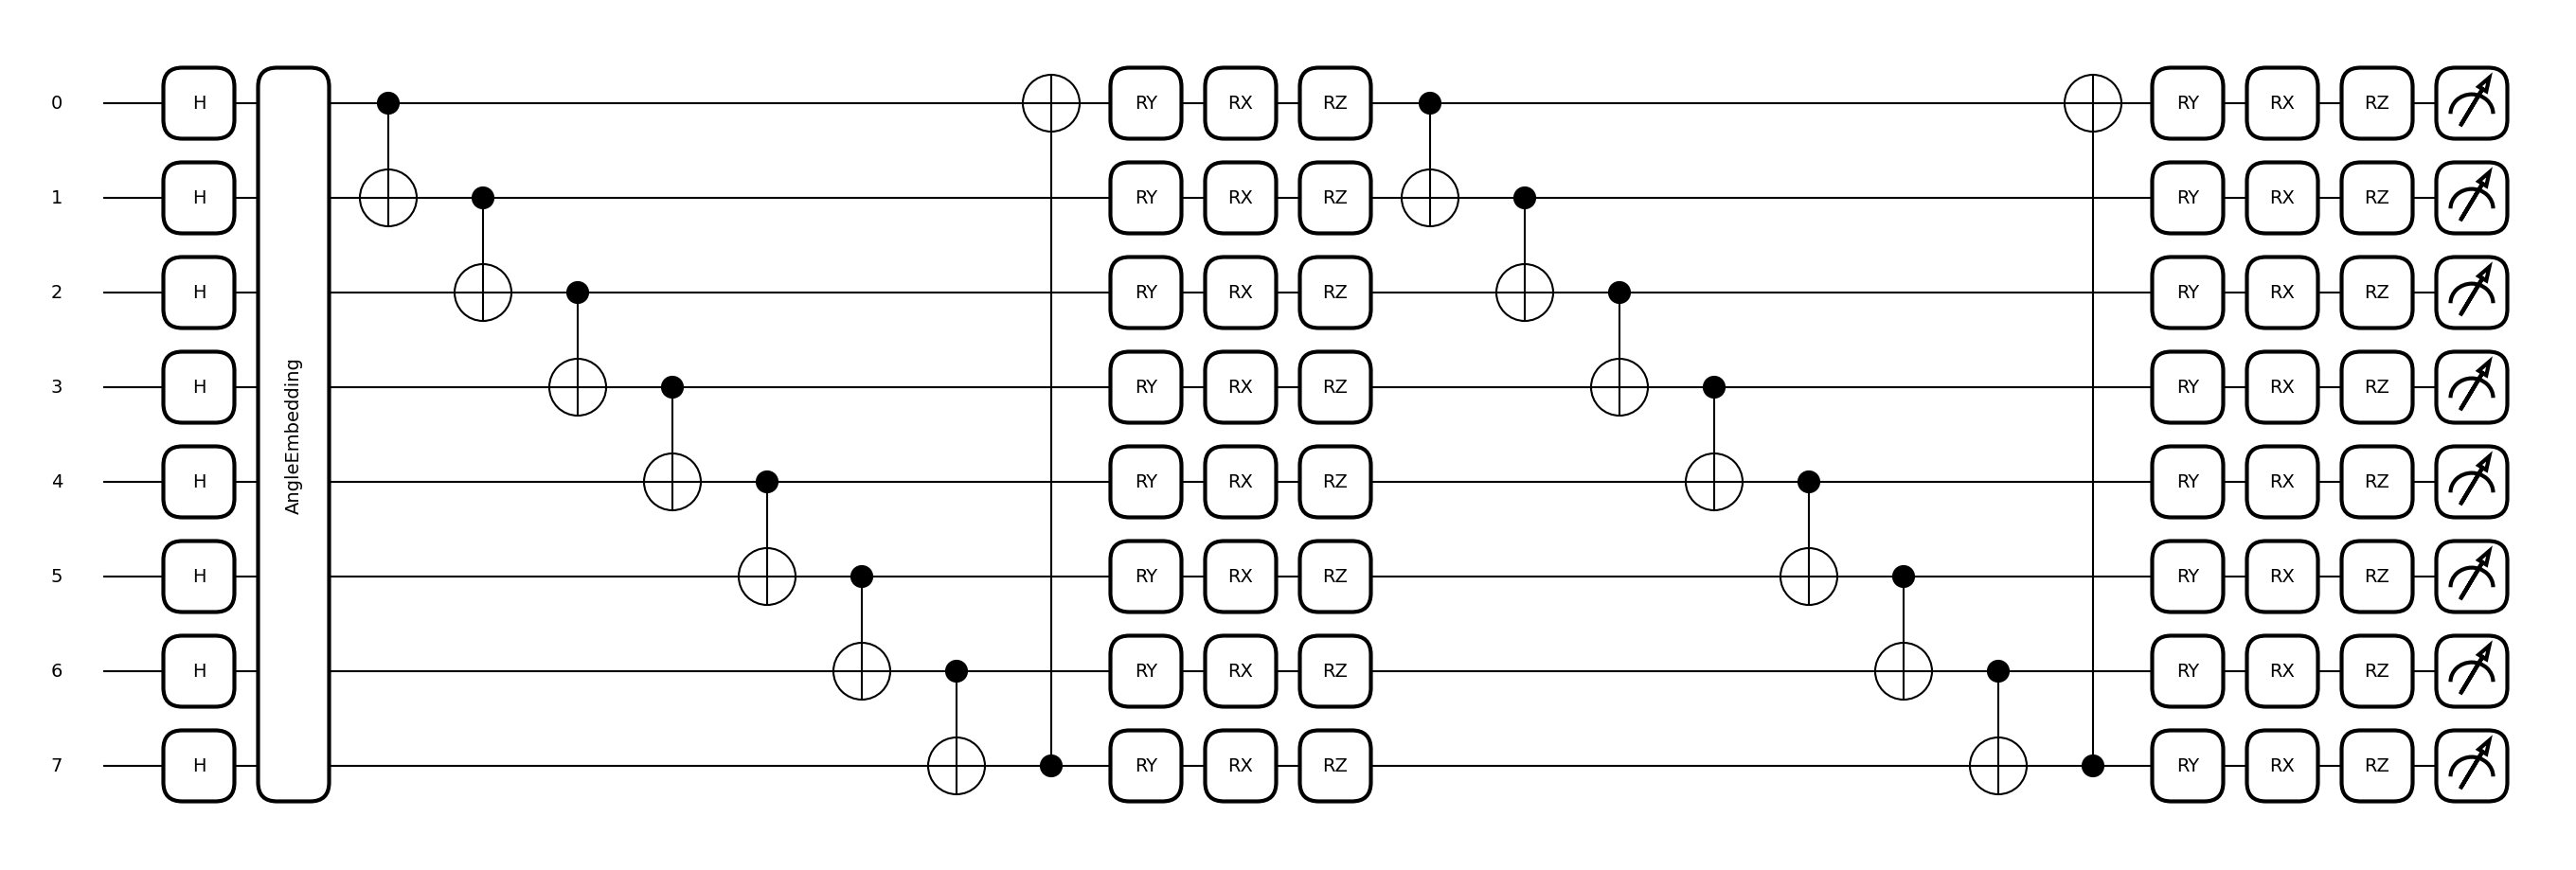

In [4]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit)(rand_features, rand_weights)
plt.show

# Dataset

In [5]:
from src.EuroSAT import EuroSAT

n_classes = 10

dataset = EuroSAT(root= 'EuroSAT_RGB',
                        num_classes=n_classes,
                        image_size=64,
                        examples_per_class=1000,
                        batch_size=batch_size,
                        allowed_classes=None)


train_loader, test_loader = dataset.get_loaders()

Class distribution in the train set:
	AnnualCrop (Class 0): 800 examples
	Forest (Class 1): 800 examples
	HerbaceousVegetation (Class 2): 800 examples
	Highway (Class 3): 800 examples
	Industrial (Class 4): 800 examples
	Pasture (Class 5): 800 examples
	PermanentCrop (Class 6): 800 examples
	Residential (Class 7): 800 examples
	River (Class 8): 800 examples
	SeaLake (Class 9): 800 examples
Class distribution in the validation set:
	AnnualCrop (Class 0): 200 examples
	Forest (Class 1): 200 examples
	HerbaceousVegetation (Class 2): 200 examples
	Highway (Class 3): 200 examples
	Industrial (Class 4): 200 examples
	Pasture (Class 5): 200 examples
	PermanentCrop (Class 6): 200 examples
	Residential (Class 7): 200 examples
	River (Class 8): 200 examples
	SeaLake (Class 9): 200 examples


![alt](assets/eurosat_overview.jpg)

# Model

In [6]:
from src.QNN4ESAT import QNN4ESAT

model = QNN4ESAT(circuit, weight_shapes, n_qubits, "n", n_classes)

Number of trainable parameters:  76654


![alt](assets/arq.png)

Extension of the `HQNN-Parallel` model presented in https://arxiv.org/abs/2304.09224.

# Training

In [7]:
from src.Trainer import Trainer

trainer = Trainer()


Epoch [1/10] - Training Summary:
    Train Loss: 2.1793, Accuracy: 28.18%
    Time spent training: 512.88 seconds

Validation Results - Epoch:
    Loss: 2.2092, Accuracy: 25.15%
    Precision: 0.6231, Recall: 0.2515, F1 Score: 0.1984
    Confusion Matrix:
[[200   0   0   0   0   0   0   0   0   0]
 [ 97 100   0   0   0   3   0   0   0   0]
 [171   6   0   0   2  21   0   0   0   0]
 [146  10   0   0   1  37   0   5   1   0]
 [ 54   0   0   0 108   2   0  36   0   0]
 [178   0   0   0   0  22   0   0   0   0]
 [190   0   0   0   0   8   0   2   0   0]
 [ 26   2   0   0  10  89   0  73   0   0]
 [157  22   0   0   0  16   0   5   0   0]
 [130  70   0   0   0   0   0   0   0   0]]
    Time spent testing: 127.19 seconds


Epoch [2/10] - Training Summary:
    Train Loss: 2.0178, Accuracy: 45.15%
    Time spent training: 516.92 seconds

Validation Results - Epoch:
    Loss: 2.0622, Accuracy: 40.05%
    Precision: 0.6274, Recall: 0.4005, F1 Score: 0.3242
    Confusion Matrix:
[[175   9   0  

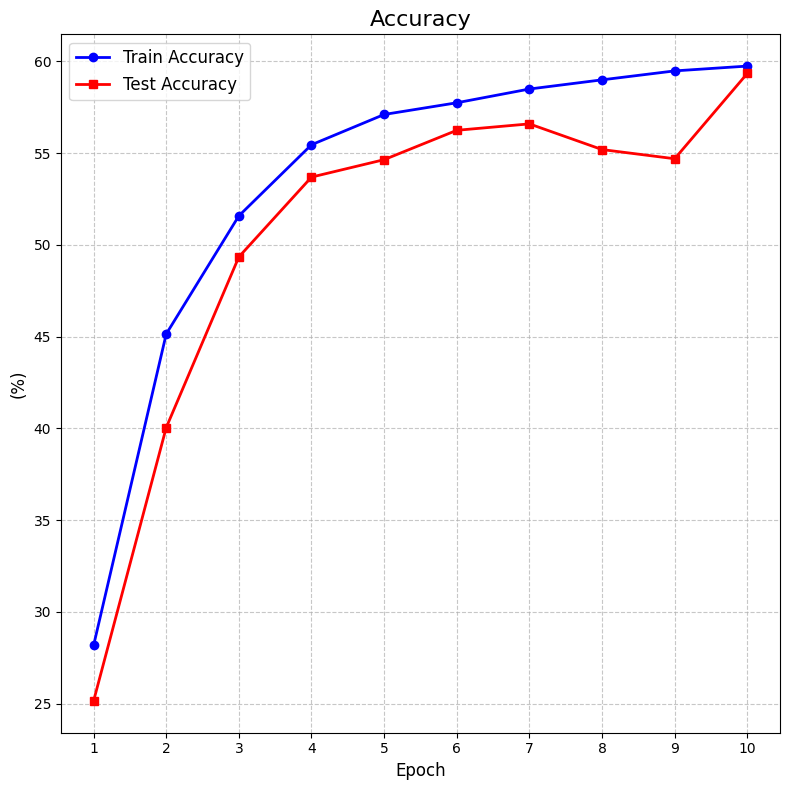

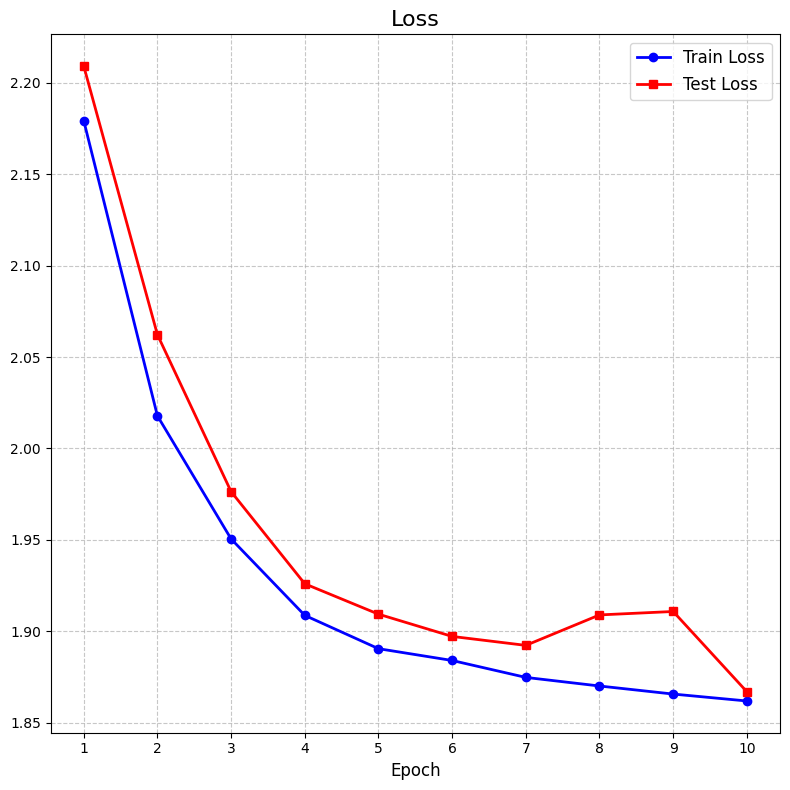

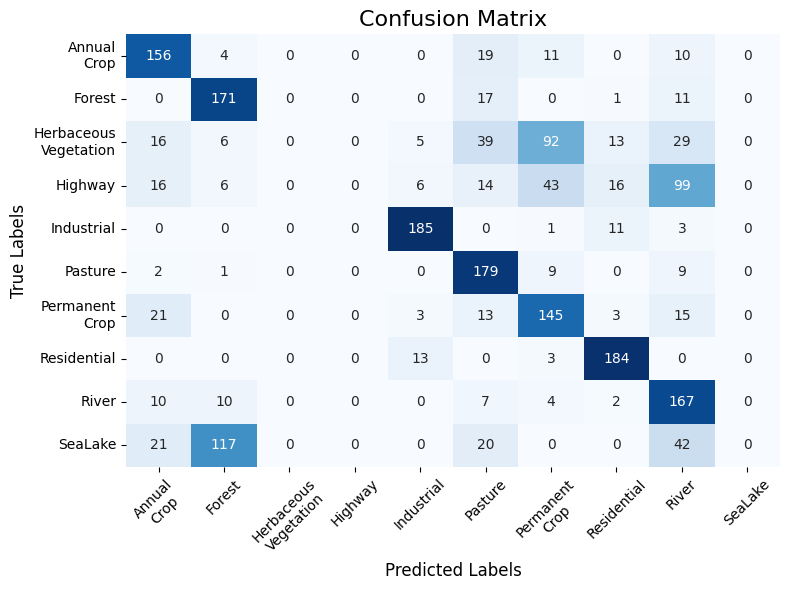

In [8]:
trainer.train_model(train_loader,
                    test_loader,
                    model,
                    'cpu',
                    opt.AdamWScheduleFree(model.parameters(), weight_decay=1e-3),
                    10,
                    True,
                    False)